In [539]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)

# from collocation import compute_weights, lagrange_derivative

import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

,settlement_date,temperature,precip,cloudcover,humidity,windspeed,conditions,nd,pump_storage_pumping,is_holiday
0,2010-01-01 00:00:00,2.50,0.0,43.60,75.520,16.20,Partially cloudy,36453.0,306.0,1.0
1,2010-01-01 00:30:00,1.55,0.0,39.85,80.855,15.10,Partially cloudy,36680.0,223.0,1.0
2,2010-01-01 01:00:00,0.60,0.0,36.10,86.190,14.00,Partially cloudy,36343.0,288.0,1.0
3,2010-01-01 01:30:00,0.70,0.0,42.45,85.665,15.35,Partially cloudy,35362.0,291.0,1.0
4,2010-01-01 02:00:00,0.80,0.0,48.80,85.140,16.70,Partially cloudy,34366.0,361.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   settlement_date       17520 non-null  object 
 1   temperature           17520 non-null  float64
 2   precip                17520 non-null  float64
 3   cloudcover            17520 non-null  float64
 4   humidity              17520 non-null  float64
 5   windspeed             17520 non-null  float64
 6   conditions            17520 non-null  object 
 7   nd                    17520 non-null  float64
 8   pump_storage_pumping  17520 non-null  float64
 9   is_holiday            17520 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.3+ MB


None

settlement_date         0
temperature             0
precip                  0
cloudcover              0
humidity                0
windspeed               0
conditions              0
nd                      0
pump_storage_pumping    0
is_holiday              0
dtype: int64

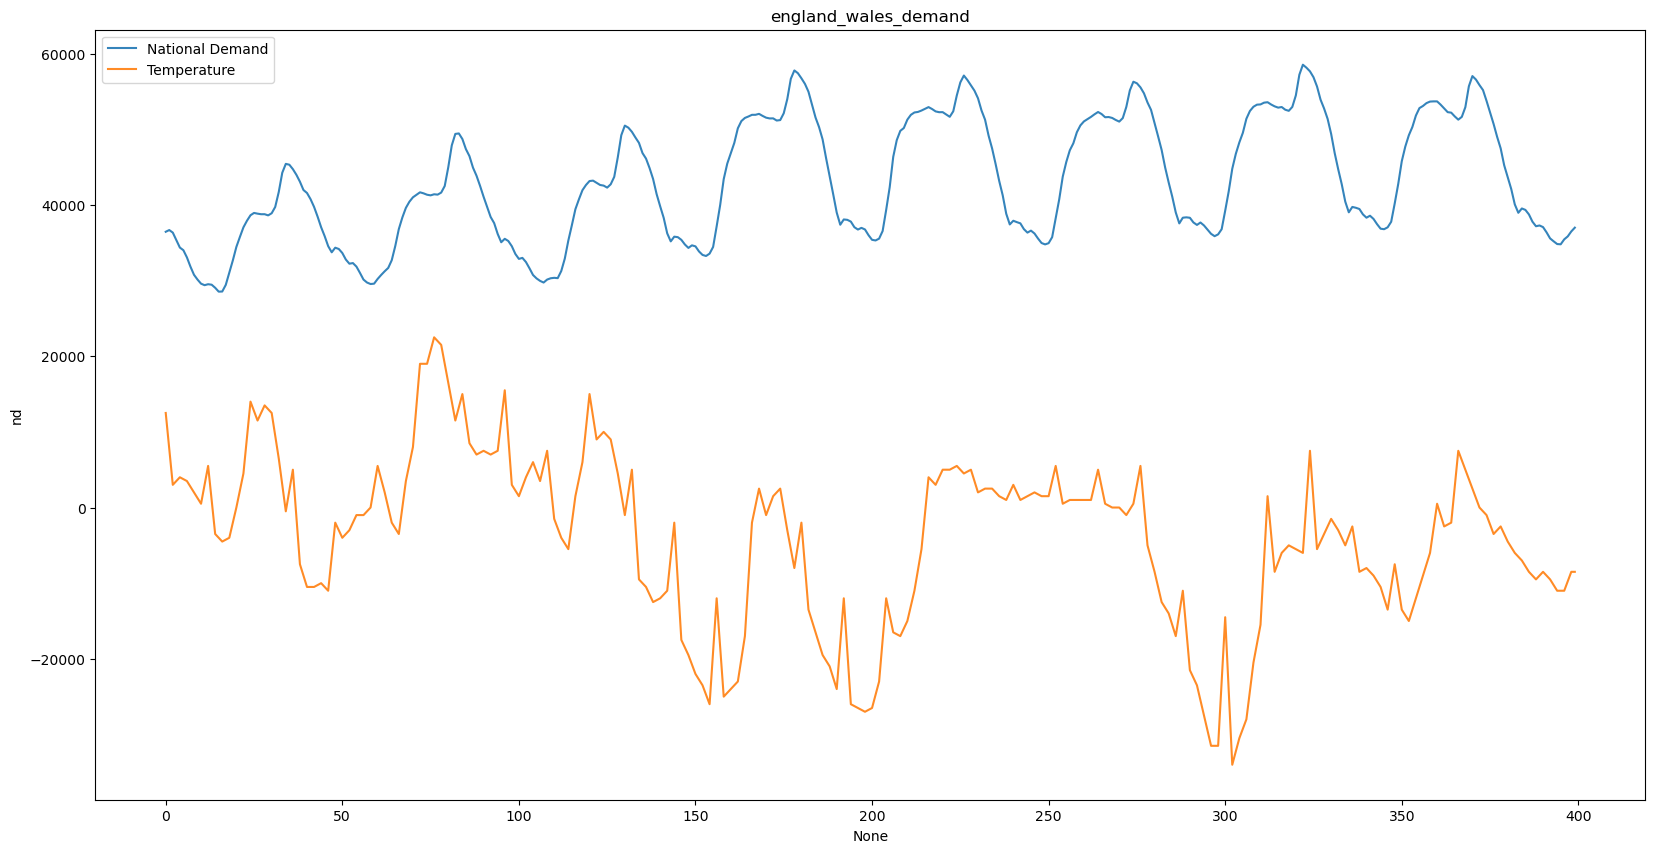

In [540]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

display(data.head())
display(data.info())
display(data.isna().sum())

end = 400
data_subsample = data[:end]
data_subsample.shape

plt.figure(figsize=(20, 10))
sns.lineplot(x=data_subsample.index, y="nd", data=data_subsample, label="National Demand", alpha = 0.9) 
sns.lineplot(x=data_subsample.index, y=(data_subsample.temperature)*5000, data=data_subsample, label="Temperature", alpha = 0.9) 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

## Split Data

In [541]:
split = 300

data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

X = data_subsample.drop('nd', axis=1) 
y = data_subsample['nd'] 
X = X[['temperature', 'hour']]

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_67912/986468755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


## Scale data

In [542]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [543]:
t = jnp.linspace(0., 1., end)

t_train = t[:split]
t_test = t[split:]

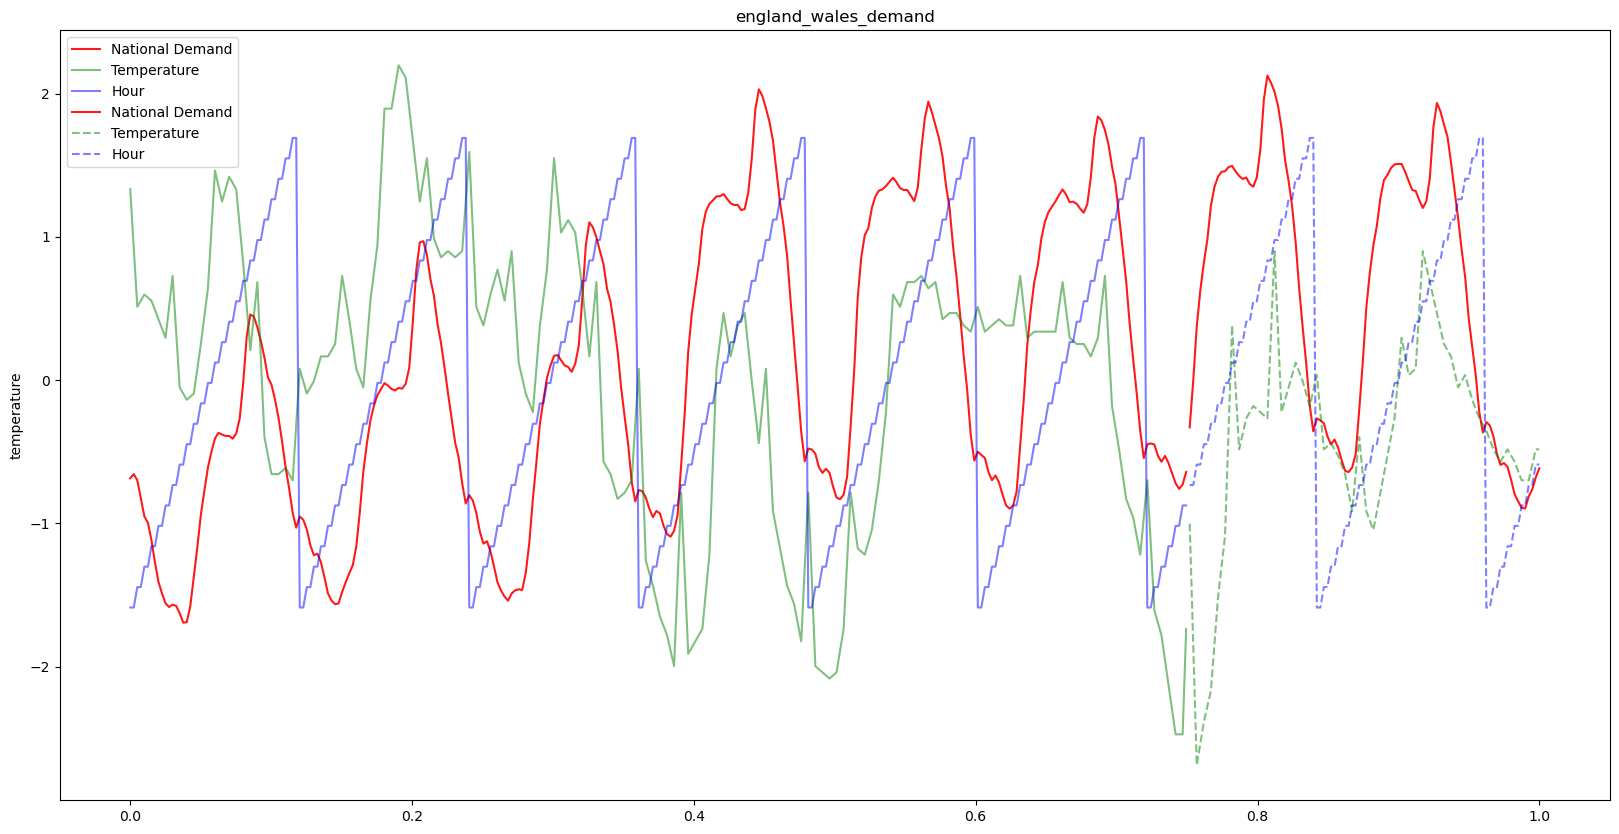

In [544]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=t_train, y=np.squeeze(y_train_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_train, y=X_train_scaled['temperature'], label="Temperature", alpha = 0.5, color='green') 
sns.lineplot(x=t_train, y=X_train_scaled['hour'], label="Hour", alpha = 0.5, color='blue') 

sns.lineplot(x=t_test, y=np.squeeze(y_test_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_test, y=X_test_scaled['temperature'], label="Temperature", alpha = 0.5, color='green', ls = '--') 
sns.lineplot(x=t_test, y=X_test_scaled['hour'], label="Hour", alpha = 0.5, color='blue', ls = '--') 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

## Train on Auxiliary Variables

In [545]:
print(t_train.shape)
print(y_train_scaled.shape)
print(X_train_scaled.shape)

(300,)
(300, 1)
(300, 2)


In [546]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)


tau = 48
m = 2
offset = tau*m
embeddings_train = create_delayed_embeddings(y_train_scaled, tau, m)

In [547]:
offset = tau*m

#---------------------------PREPARE THE EXTRA ARGUMENTS--------------------------#
X_train_scaled_jnp = jnp.array(X_train_scaled[offset:])
X_train_scaled_embed = jnp.concatenate([X_train_scaled_jnp, embeddings_train], axis = 1)

ts = t_train[offset:]
ys = jnp.array(y_train_scaled)[offset:]
y0 = y_train_scaled[offset]
extra_args = (jnp.array(X_train_scaled_embed), ts)

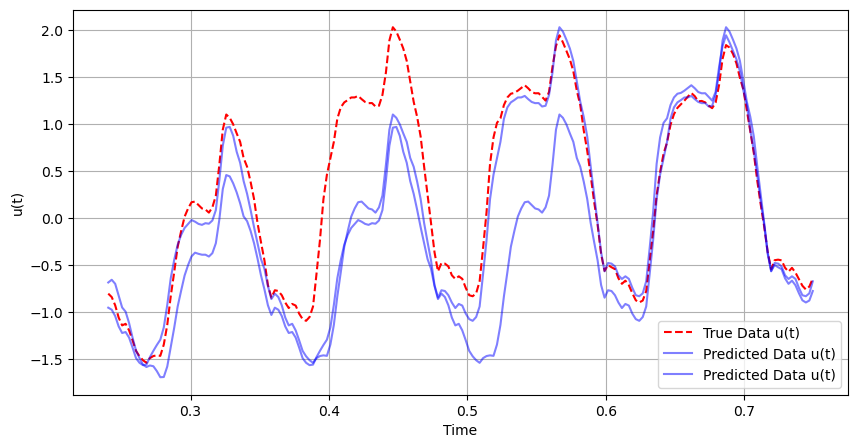

In [548]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, embeddings_train, 'b', label='Predicted Data u(t)', alpha = 0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

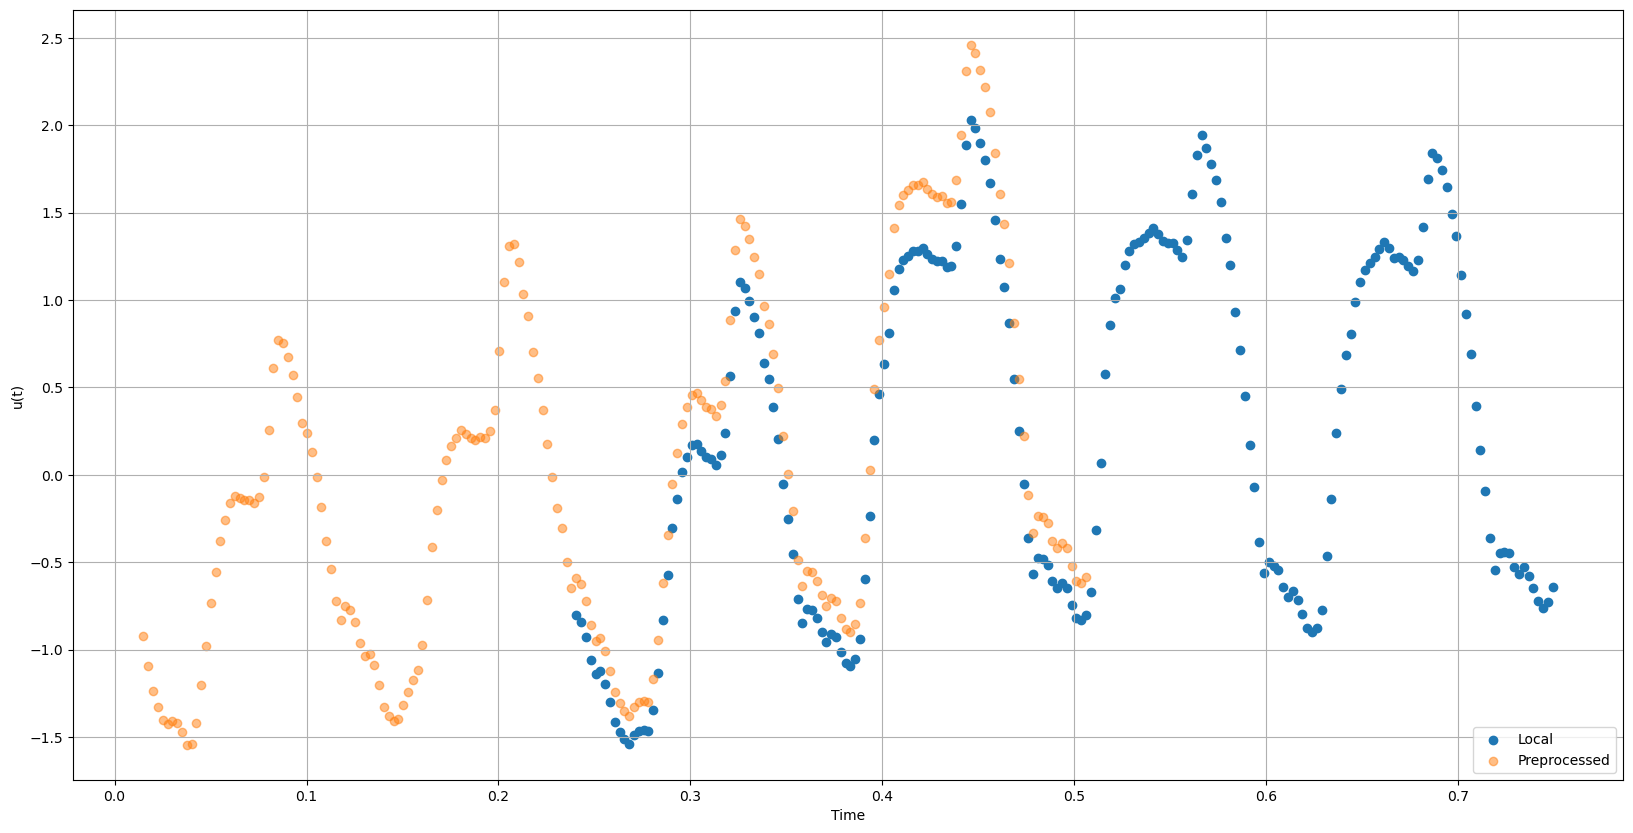

In [549]:
df = pd.read_csv('../04_energy_consumption_reformat/df_train_preprocessed.csv')

ts = t_train[offset:]
ys = jnp.array(y_train_scaled)[offset:]
y0 = y_train_scaled[offset]
extra_args = (jnp.array(X_train_scaled_embed), t_train[offset:])

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(20, 10))

plt.scatter(ts, ys, label='Local')  
plt.scatter(df['t'], df['y'], label='Preprocessed', alpha = 0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [550]:
ts_pre.shape

(197,)

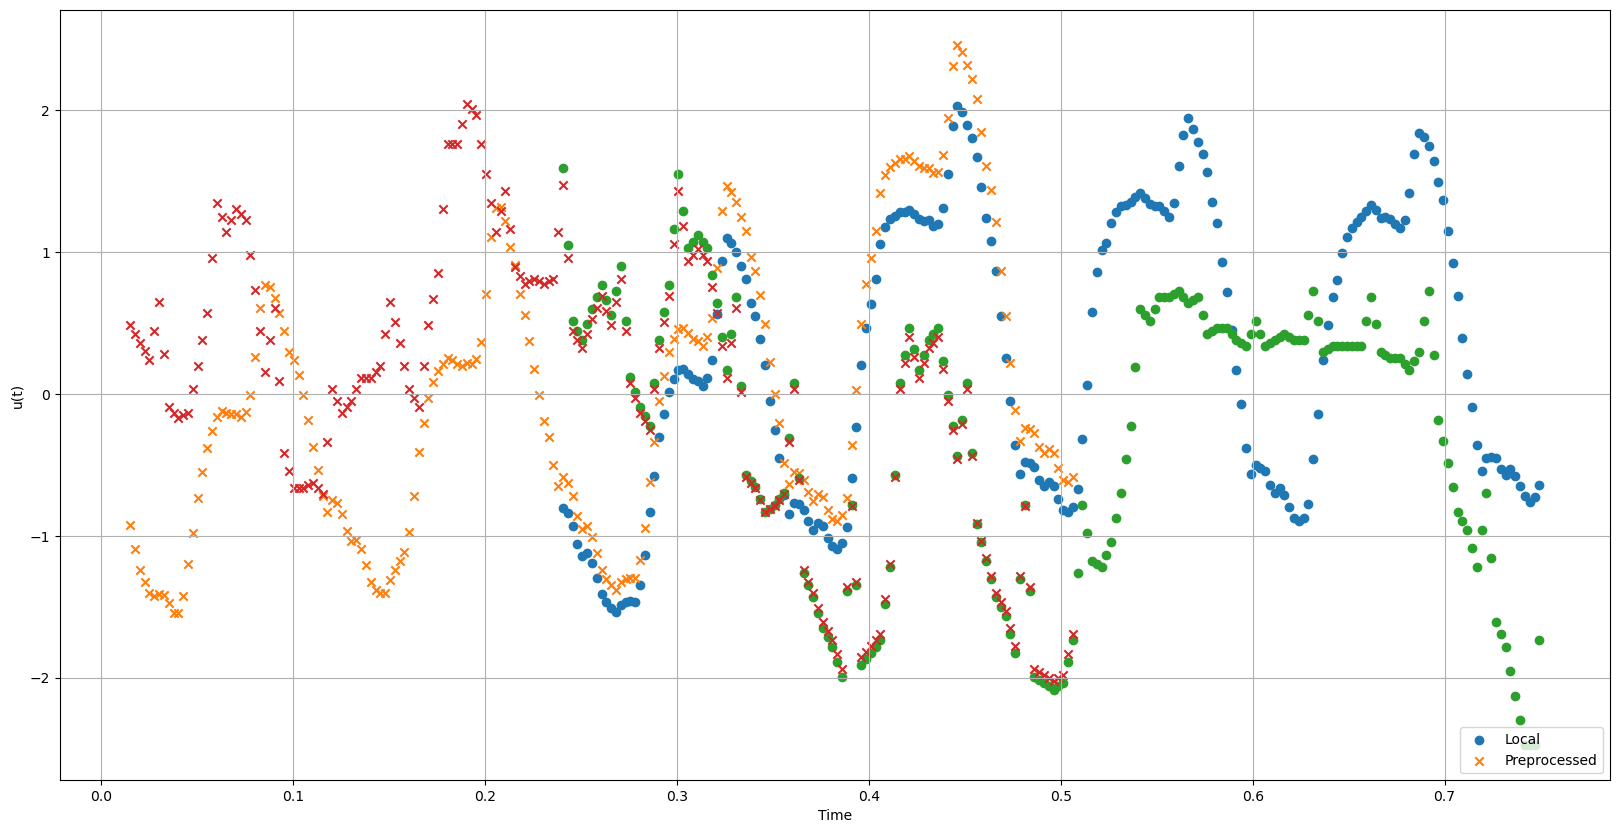

In [551]:
df = pd.read_csv('../04_energy_consumption_reformat/df_train_preprocessed.csv')

ts = t_train[offset:]
ys = jnp.array(y_train_scaled)[offset:]
y0 = y_train_scaled[offset]
extra_args = (jnp.array(X_train_scaled_embed), t_train[offset:])

update = True
if update:
    ys_pre = jnp.atleast_2d(jnp.array(df['y'])).T
    ts_pre = jnp.array(df['t'])
    Xs_pre = jnp.array(df.drop(columns=['y', 't']))
    extra_args_pre = (Xs_pre, ts_pre)
    y0_pre = jnp.array([ys_pre[0]])

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(20, 10))

#plt.scatter(ts, ys, label='Local')  
#plt.scatter(df['t'], df['y'], label='Preprocessed', alpha = 0.5) 

plt.scatter(ts, ys, label='Local')  
plt.scatter(ts_pre, ys_pre, label='Preprocessed', alpha = 1, marker='x') 

k = 0

for i in range(len(X_train_scaled_embed.T)):
    if i != k:
        continue
    plt.scatter(ts, X_train_scaled_embed.T[i]) 

for i in range(len(X_train_scaled_embed.T)):
    if i != k:
        continue
    plt.scatter(ts_pre, Xs_pre.T[i], alpha = 1, marker='x') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

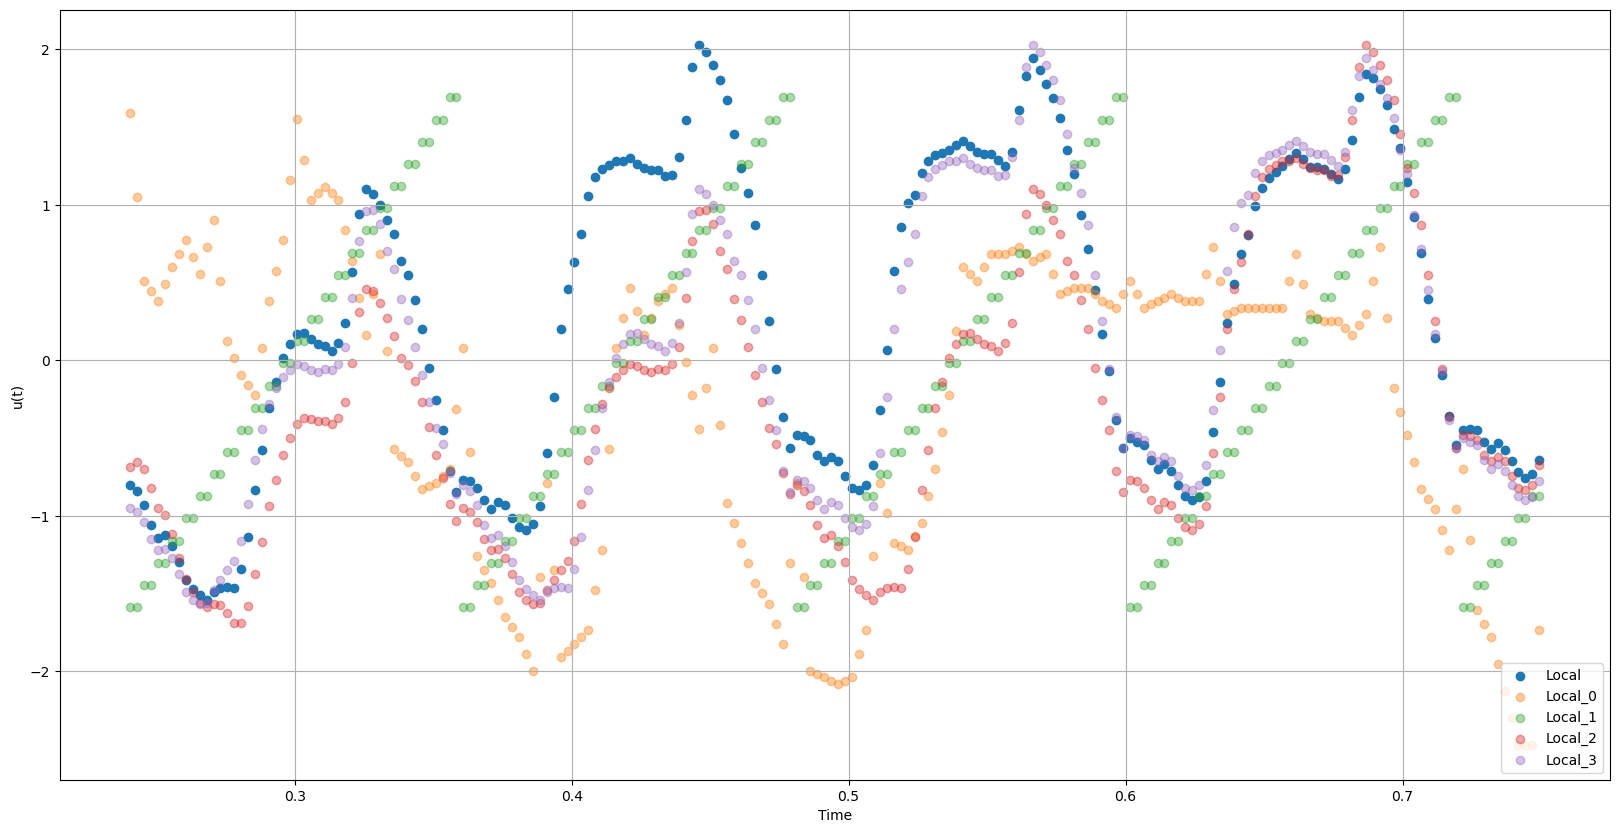

In [552]:
plt.figure(figsize=(20, 10))

#plt.scatter(ts, ys, label='Local')  
#plt.scatter(df['t'], df['y'], label='Preprocessed', alpha = 0.5) 

plt.scatter(ts, ys, label='Local')  
#plt.scatter(ts_pre, ys_pre, label='Preprocessed', alpha = 1, marker='x') 

k = 2

for i in range(len(X_train_scaled_embed.T)):
    plt.scatter(ts, X_train_scaled_embed.T[i], alpha = 0.4, label=f'Local_{i}') 


plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [553]:
import neural_net_jax_diffrax
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

layer_widths = [5, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

state = node_model.train(state, ts 
                         , ys, y0
                         , num_epochs = 10000
                         , extra_args=extra_args
                         )

Epoch 100, Loss: 170.20053804719248
Epoch 200, Loss: 146.8532316820253
Epoch 300, Loss: 134.5549906487341
Epoch 400, Loss: 131.39062108539773
Epoch 500, Loss: 122.28792306608436
Epoch 600, Loss: 138.44234358523576
Epoch 700, Loss: 128.07480919739388
Epoch 800, Loss: 122.36315027364333
Epoch 900, Loss: 120.80094131926437
Epoch 1000, Loss: 120.08578917318263
Epoch 1100, Loss: 129.26751729477274
Epoch 1200, Loss: 117.79721939695798
Epoch 1300, Loss: 118.05405035486116
Epoch 1400, Loss: 136.2916513610691
Epoch 1500, Loss: 116.5152603803418
Epoch 1600, Loss: 117.2143331246041
Epoch 1700, Loss: 112.98329847308372
Epoch 1800, Loss: 114.45719471581322
Epoch 1900, Loss: 108.70697714577656
Epoch 2000, Loss: 103.72717302565516
Epoch 2100, Loss: 99.5062232858632
Epoch 2200, Loss: 100.6389459402881
Epoch 2300, Loss: 95.64562530335702
Epoch 2400, Loss: 96.2773381038962
Epoch 2500, Loss: 94.03696818776889
Epoch 2600, Loss: 91.58221369053138
Epoch 2700, Loss: 88.03384975130915
Epoch 2800, Loss: 90.619

### Predictions

In [554]:
import neural_net_jax_diffrax
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

# reload
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

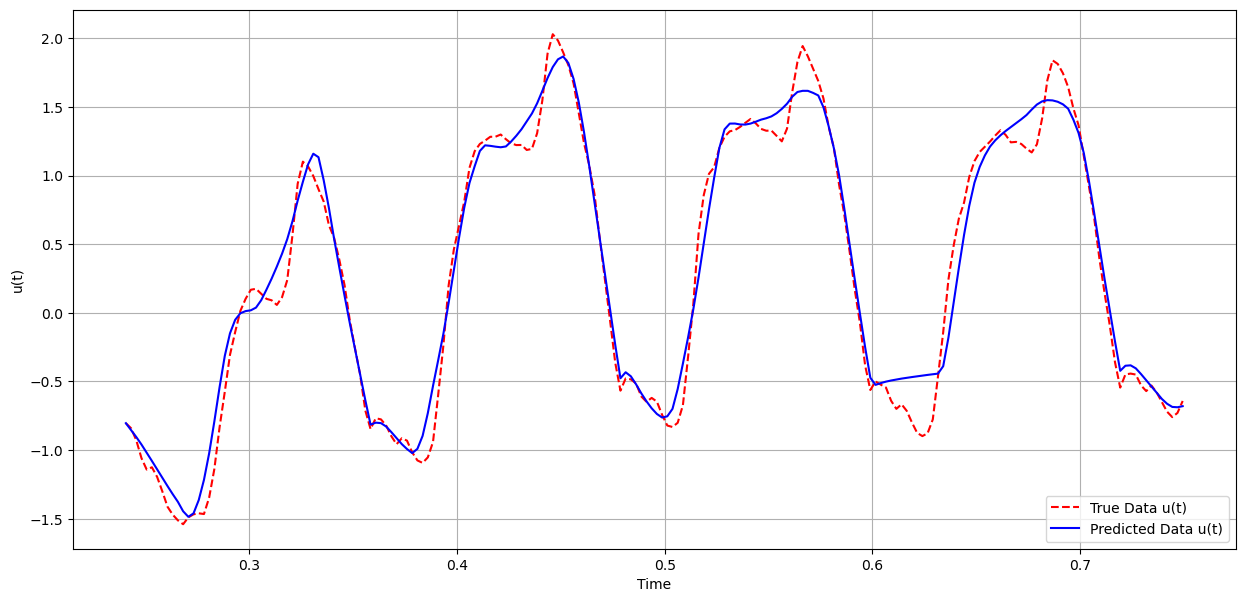

In [555]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_train_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [556]:
# create a vector to store all of embeddings
y_full_scaled = jnp.concatenate([y_train_scaled, y_test_scaled])

# ensure the test points are not leaked into the training set
y_full_scaled = np.array(y_full_scaled)
for i in range(split, len(y_full_scaled)):
    y_full_scaled[i] = np.nan

y_full_scaled = y_full_scaled

In [557]:
def fetch_embeddings(y, tau, m, index):
    # use slicing to get the embeddingsa
    return jnp.squeeze(y[index - m * tau : index : tau].T)

fetch_embeddings(y_full_scaled, tau, m, 200)

Array([-1.41257678, -1.07498033], dtype=float64)

In [558]:
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

# reload the model
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

# prepare an array to append to 
X_full_scaled_embed = jnp.array(X_train_scaled_embed)

# the last known value is: (split - 1) 
init_value = jnp.array([y_train_pred[-1][0]])

@jit
def process_current_value(state, init_value, t_predict, X_full_scaled_embed, t_full):
    extra_args = (X_full_scaled_embed, t_full)
    return node_model.neural_ode(state.params, init_value, t_predict, state, extra_args)[1]

# loop over each test point, starting at the split point
for current_index in range(split, len(y_full_scaled)):
    if current_index % 10 == 0:
        print(f'Processing index: {current_index}')
    # fetch the embedding for the current index
    embeddings_row = fetch_embeddings(y_full_scaled, tau, m, current_index)

    if np.isnan(embeddings_row).any():
        print('There are missing values in the embeddings')

    # fetch the X values for the current index
    X_test_scaled_row = jnp.array(X_test_scaled.iloc[current_index - split])

    # append 1D rows
    current_row = jnp.append(X_test_scaled_row, embeddings_row)
    X_full_scaled_embed = jnp.vstack([X_full_scaled_embed, current_row])

    # define time arrays
    t_full = jnp.array(t[offset:current_index + 1])
    t_predict = jnp.array(t[current_index - 1:current_index + 1])

    # call the JIT-compiled function to process the current value
    # calling ODE solver
    current_value = process_current_value(state, init_value, t_predict, X_full_scaled_embed, t_full)

    # update the initial value for the next iteration
    init_value = current_value

    # save the current value to the noisy embeddings
    y_full_scaled[current_index] = current_value

Processing index: 300
Processing index: 310
Processing index: 320
Processing index: 330
Processing index: 340
Processing index: 350
Processing index: 360
Processing index: 370
Processing index: 380
Processing index: 390


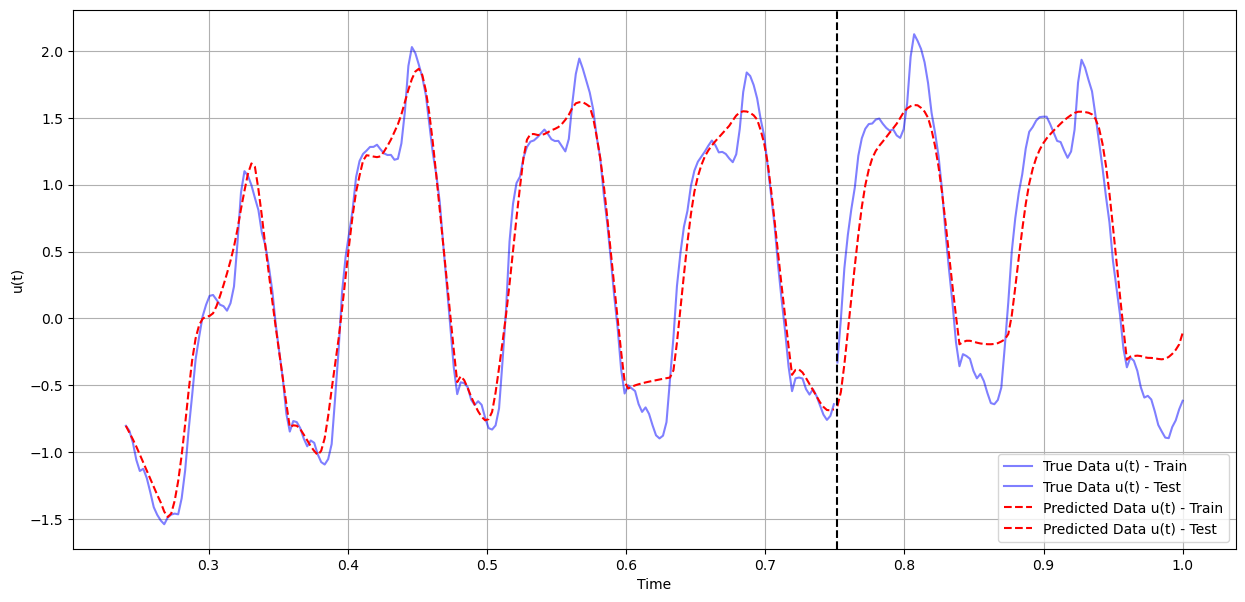

In [559]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'b', label='True Data u(t) - Train', alpha = 0.5)  
plt.plot(t_test, y_test_scaled, 'b', label='True Data u(t) - Test', alpha = 0.5) 
plt.plot(ts, y_train_pred, 'r--', label='Predicted Data u(t) - Train') 
plt.plot(t[split:], y_full_scaled[split:], 'r--', label='Predicted Data u(t) - Test') 
plt.axvline(x=t[split], color='black', linestyle='--')

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Will the ContiniousVar Pyomo model work with the same data inputs?

In [560]:
# The inputs are:
update = False

if update:
    ts = t_train[offset:]
    ys = jnp.array(y_train_scaled)[offset:]
    y0 = y_train_scaled[offset]
    extra_args = (jnp.array(X_train_scaled_embed), t_train[offset:])

In [561]:
path_ = os.path.abspath(os.path.join('..', '04_energy_consumption_reformat'))

if path_ not in sys.path:
    sys.path.append(path_)

In [562]:
ys.shape

(204, 1)

In [563]:
import nn_pyomo
importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [5, 30, 1]

# solver.options['print_level'] = 5
tol = 1e-4
params = {"tol":1e-4, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # "mu_strategy": 'adaptive', 
          # "check_derivatives_for_naninf": 'yes',
          # 'nlp_scaling_method' = 'gradient-based',
          # 'linear_solver'] = 'ma57',
          "max_iter": 1000 }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(X_train_scaled_embed),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(ys), 
                           penalty_lambda_reg = 0.01, 
                           penalty_lambda_input = 0.0000,
                           # constraint_penalty = 1e-5,  
                           time_invariant = True,
                           extra_input = np.array(X_train_scaled_embed), # X
                           w_init_method = 'xavier', 
                           params = params,
                           constraint="l1",
                           deriv_method="pyomo"
                           )

ode_model.build_model()
end_timer_build = time.time()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   132762
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   129341

Total number of variables............................:     1430
         

In [564]:
derivative = ode_model.extract_derivative()
derivative = derivative[1:]

ERROR: evaluating object as numeric value: dy_dt[0.24060150375939848]
        (object: <class 'pyomo.core.base.var.VarData'>)
    No value for uninitialized NumericValue object dy_dt[0.24060150375939848]


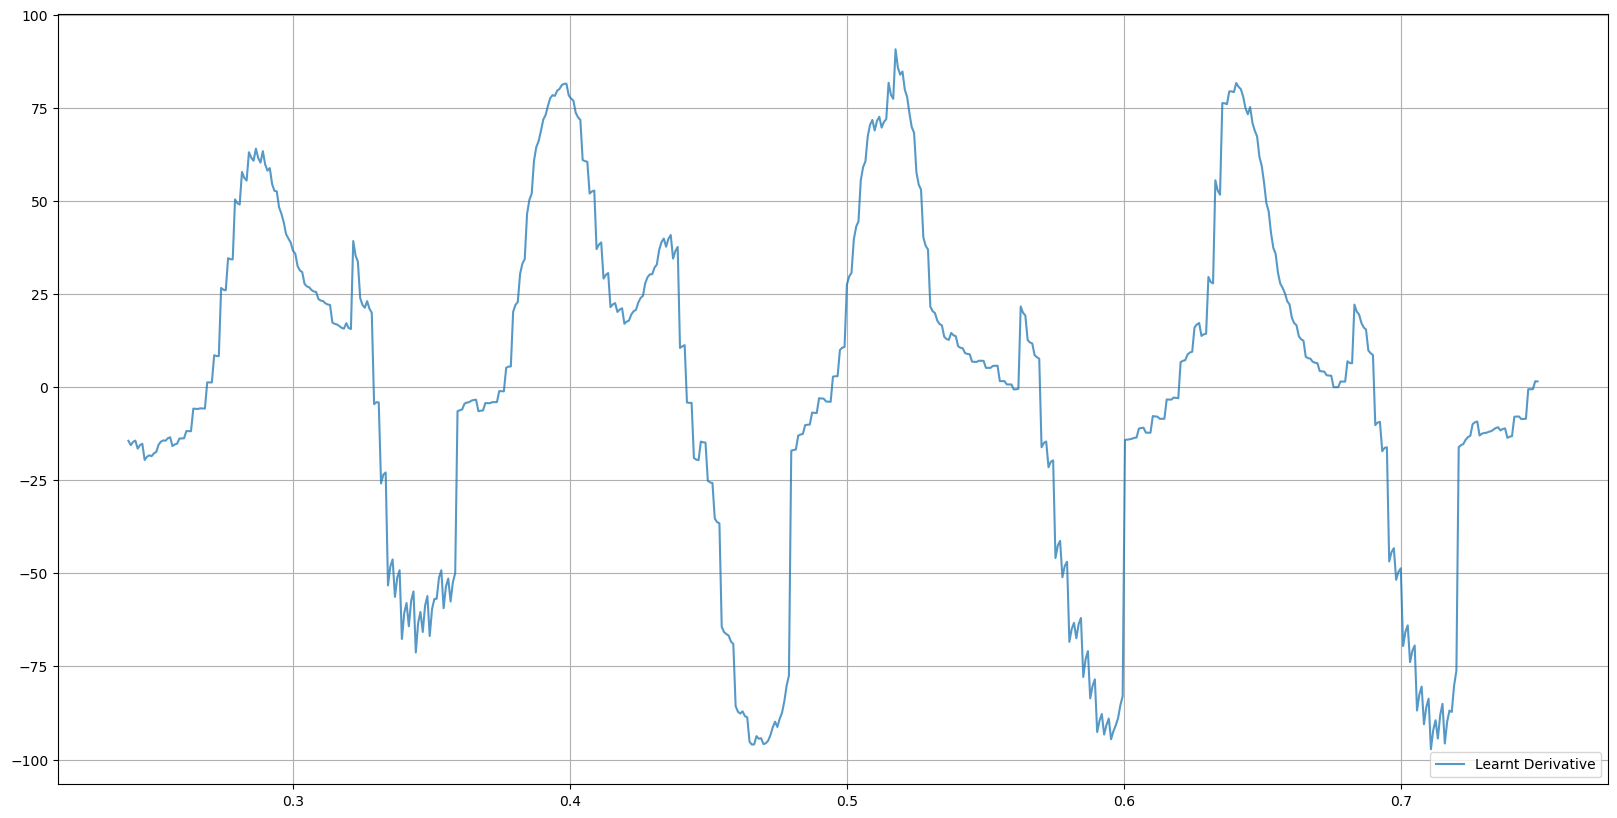

In [567]:
plt.figure(figsize=(20, 10))
plt.plot(jnp.linspace(min(ts), max(ts), len(derivative)), derivative, label='Learnt Derivative', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Mean Absolute Error - Direct: 0.16751134829865608
Mean Absolute Error - ODE solver: 6.829564337973181


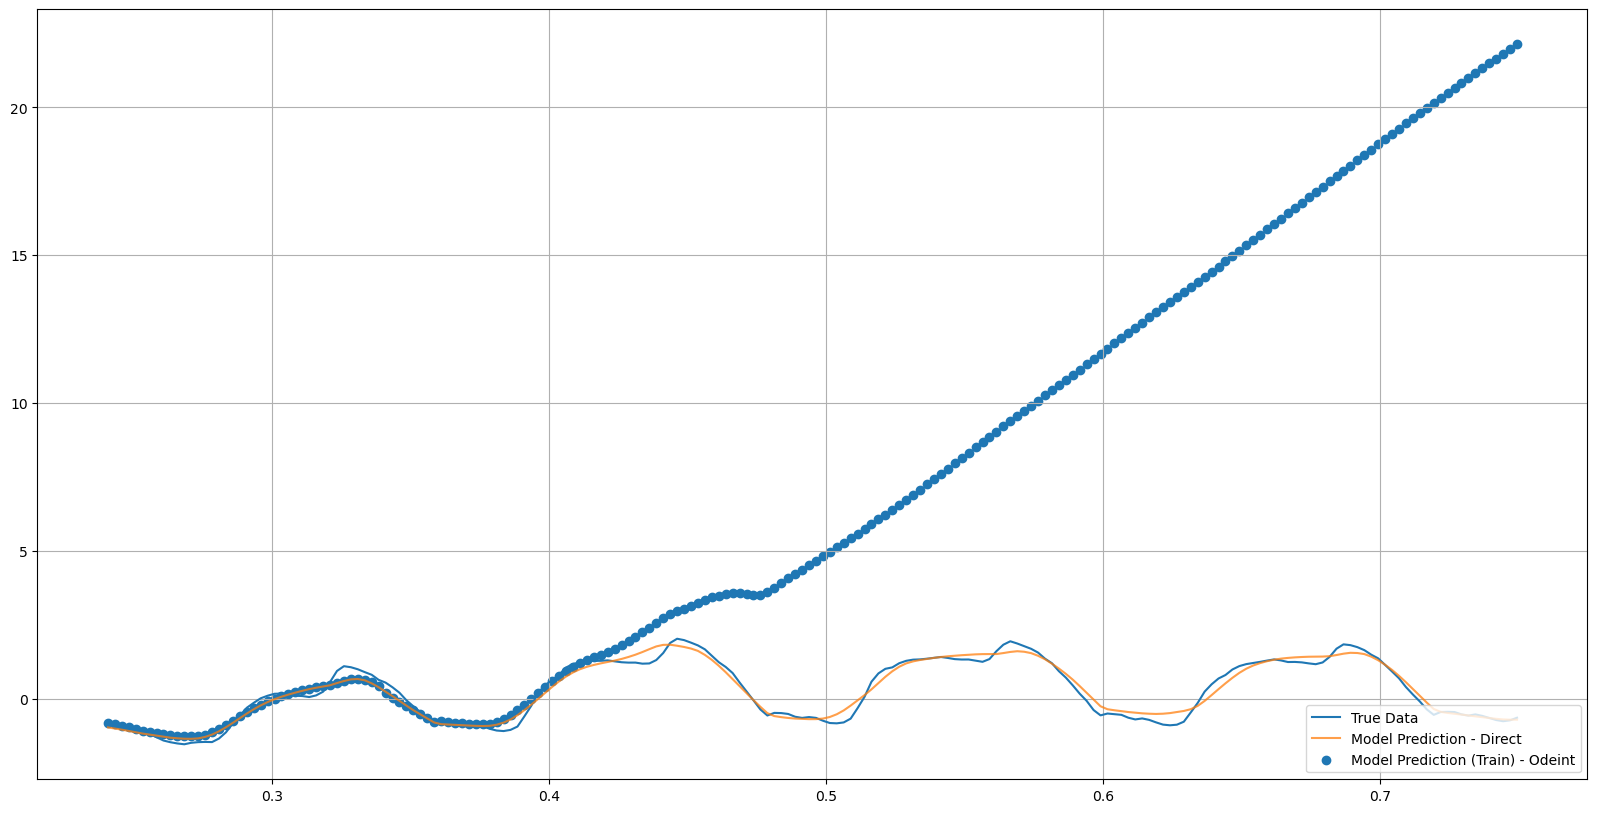

In [568]:
y0 = ys[0]
# step_1 = 150
y_pred = ode_model.neural_ode(y0, ts, (X_train_scaled_embed, ts))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")


plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)

plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Can we use collocation instead of a sequential solver to extract the solution?

In [569]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]


In [570]:
u_model[0]

-0.9693047461208244

In [572]:
import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-2
params = {"tol":1e-2, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 300 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(X_train_scaled_embed), params=params)

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4266
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      610

Total number of variables............................:     1220
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
     

ApplicationError: Solver (ipopt) did not exit normally

In [526]:
print(X_full_scaled_embed.shape)
print(X_train_scaled_embed.shape)

(224, 4)
(204, 4)


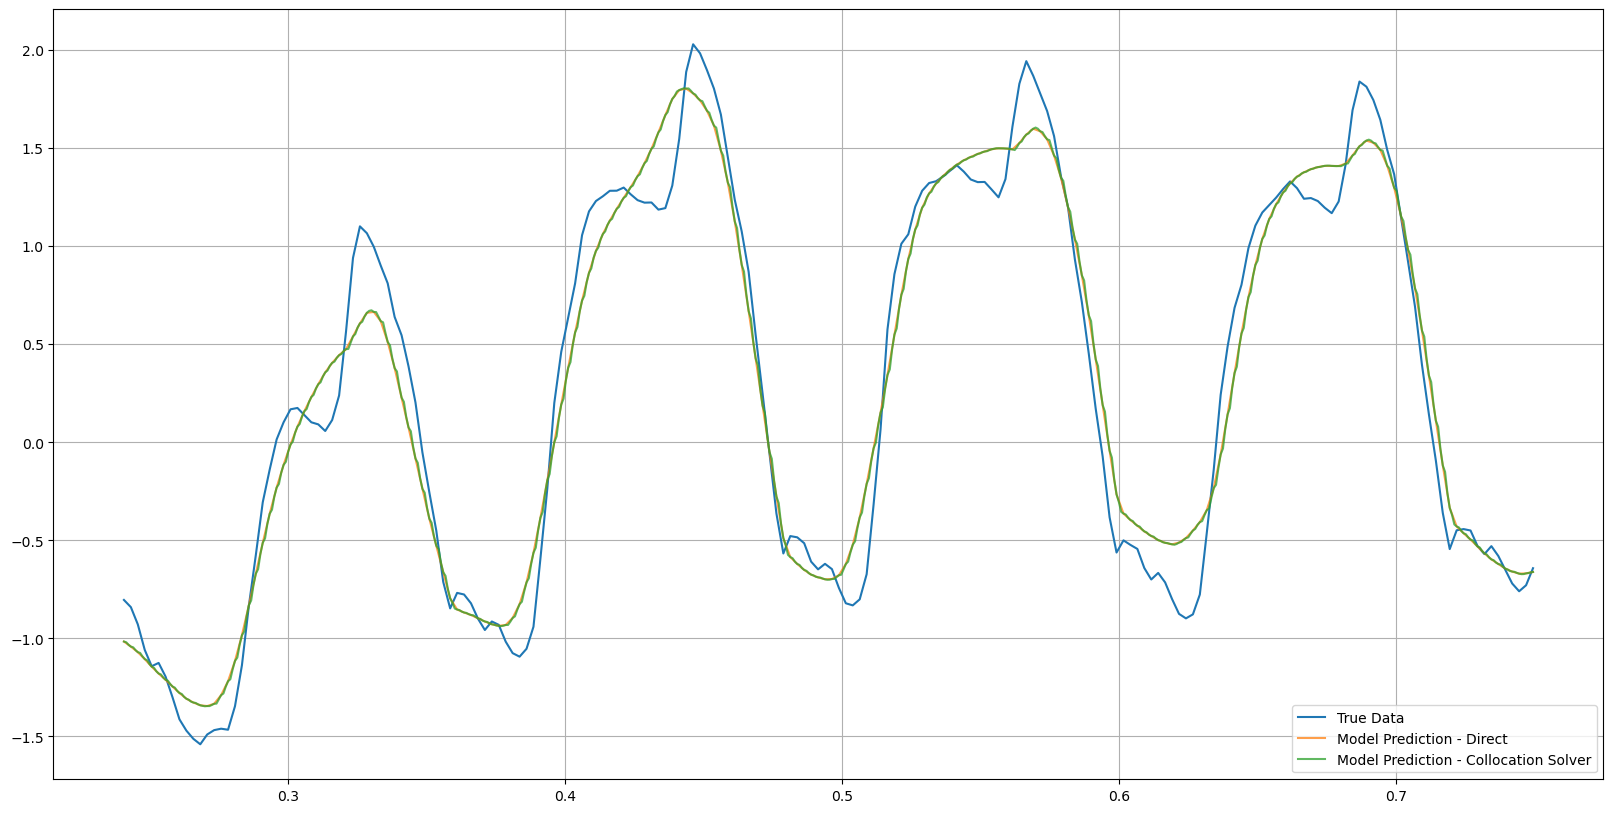

In [527]:
t_temp = np.linspace(min(ts), max(ts), len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_temp, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### How would we extend this beyond the test set?

In [532]:
# create a vector to store all of embeddings
y_full_scaled = jnp.concatenate([y_train_scaled, y_test_scaled])

# ensure the test points are not leaked into the training set
y_full_scaled = np.array(y_full_scaled)
for i in range(split, len(y_full_scaled)):
    y_full_scaled[i] = np.nan

y_full_scaled = y_full_scaled

In [529]:
def process_current_value(initial_state, t_predict, X_full_scaled_embed, t_full):
    layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]
    tol = 1e-1
    params = {"tol":1e-1, "dual_inf_tol": tol, "compl_inf_tol": tol,
              "constr_viol_tol": tol, "acceptable_iter": 0, "halt_on_ampl_error": 'yes',
              "print_level": 5, "max_iter": 80 }
    
    direct_solver = DirectODESolver(np.array(t_full), layer_sizes, trained_weights, trained_biases, initial_state, 
                                    time_invariant=True, extra_input=np.array(X_full_scaled_embed), params=params)
    
    direct_solver.build_model()
    direct_solver.solve_model()
    y_solution = direct_solver.extract_solution()
    
    return y_solution[-1]

In [536]:
# prepare an array to append to 
X_full_scaled_embed = np.array(X_train_scaled_embed)

# the last known = last value from training prediction
init_value = u_model[-1] 

# loop over each test point, starting at the split point
for current_index in range(split, len(y_full_scaled)):
    if current_index % 1 == 0:
        print(f'Processing index: {current_index}')
        
    # fetch the embedding for the current index
    embeddings_row = fetch_embeddings(y_full_scaled, tau, m, current_index)

    if np.isnan(embeddings_row).any():
        print('There are missing values in the embeddings')

    # fetch the X values for the current index
    X_test_scaled_row = np.array(X_test_scaled.iloc[current_index - split])

    # append 1D rows
    current_row = np.append(X_test_scaled_row, embeddings_row)
    X_full_scaled_embed = np.vstack([X_full_scaled_embed, current_row])

    # fefine time arrays
    t_full = np.array(t[offset:current_index + 1])
    t_predict = np.array(t[current_index - 1:current_index + 1])

    # Process the current value to get the next prediction
    current_value = process_current_value(init_value, t_predict, X_full_scaled_embed, t_full)

    # Update the initial value for the next iteration
    init_value = current_value

    # Save the current value to the noisy embeddings
    y_full_scaled[current_index] = current_value
    # break

Processing index: 300
Ipopt 3.14.16: tol=0.1
dual_inf_tol=0.1
compl_inf_tol=0.1
constr_viol_tol=0.1
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=80


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4287
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      613

Total number of variables............................:     1226
                     variables with only lower bounds:        0
                variables with lower and upper bound

ApplicationError: Solver (ipopt) did not exit normally

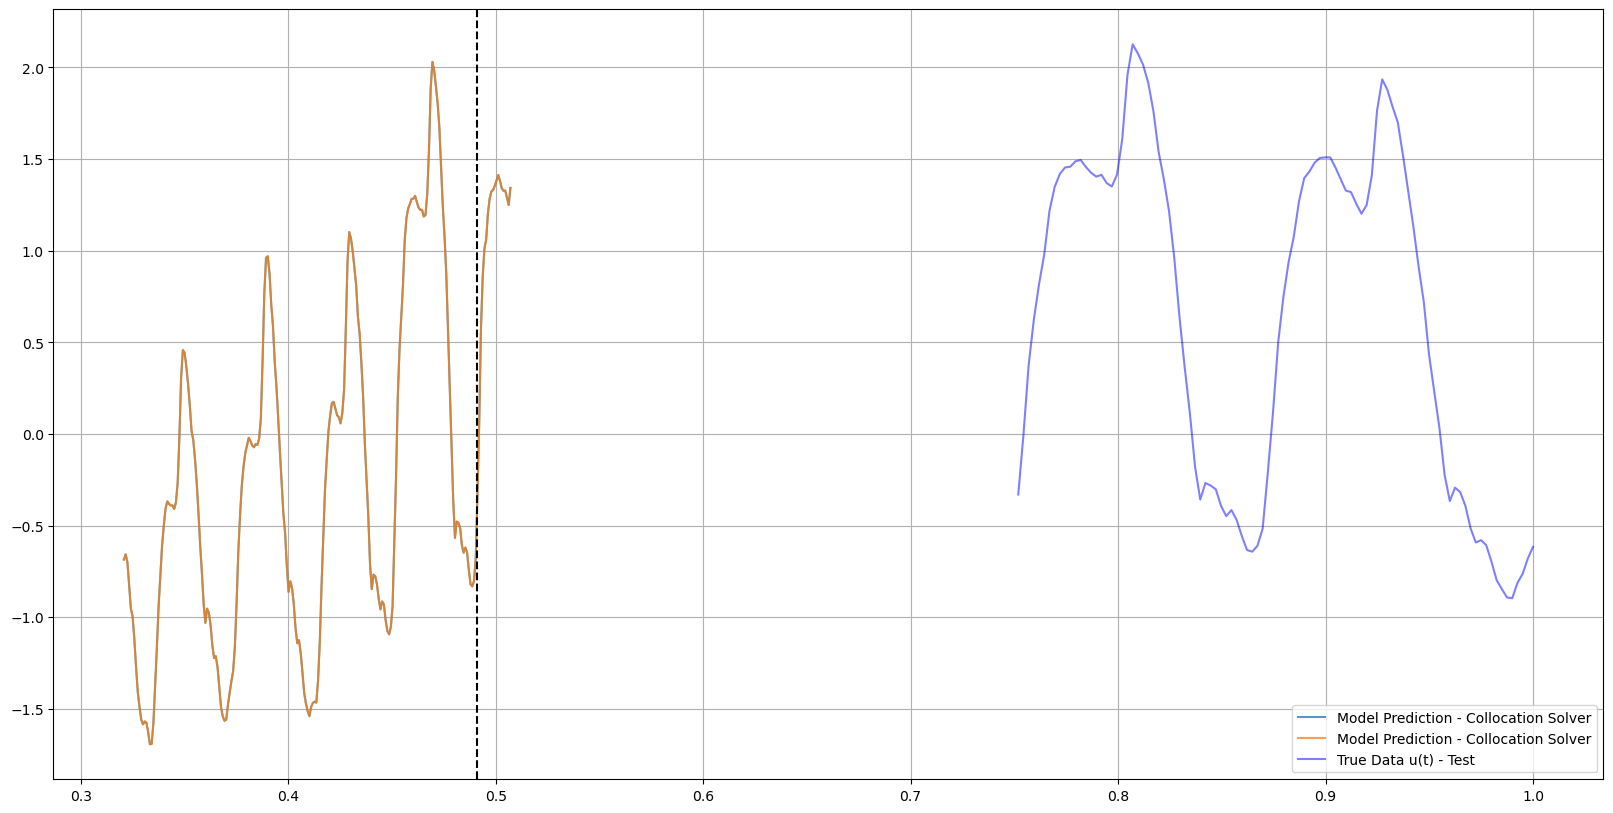

In [538]:
plt.figure(figsize=(20, 10))
plt.plot(t_full, y_full_scaled[:len(t_full)], label='Model Prediction - Collocation Solver', alpha = 0.75)
plt.plot(t_full, y_full_scaled[:len(t_full)], label='Model Prediction - Collocation Solver', alpha = 0.75)
plt.plot(t_test, y_test_scaled, 'b', label='True Data u(t) - Test', alpha = 0.5) 

plt.axvline(x = t[split], color='black', linestyle='--')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()